In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [87]:
IMAGE_SIZE = 256
BATCH_SIZE = 12
CHANNELS = 3
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
EPOCHS = 50
CLASSES_NUMBER = 3

In [88]:
# Load & Shuffle data
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "wheat_leaf",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 407 files belonging to 3 classes.


In [89]:
# Extract class names
class_names = dataset.class_names
class_names

['Healthy', 'septoria', 'stripe_rust']

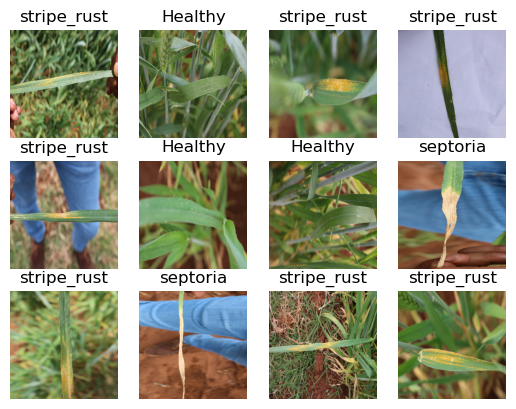

In [90]:
# Display some images with there classes
for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
      ax = plt.subplot(3,4,i+1) 
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[lable_batch[i]])
      plt.axis("off")

In [91]:
len(dataset) * 0.8

27.200000000000003

In [92]:
len(dataset)

34

In [93]:
# Split dataset to training, validation and testing datasets
train_dataset = dataset.take(28)
temp_dataset = dataset.skip(28)
validation_dataset = temp_dataset.take(3)
test_dataset = temp_dataset.skip(3)

In [94]:
len(train_dataset)

28

In [95]:
len(validation_dataset)

3

In [96]:
len(test_dataset)

3

In [97]:
# Use data caching for better performance when training the model
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [98]:
# Scale the images to 255 (Because input values should be between 0 and 1) and Resize images

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [99]:
# Data augmentation layer
# RandomCrop RandomFlip RandomTranslation RandomRotation RandomZoom RandomHeight RandomWidth RandomContrast RandomBrightness 
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2), # results in an output rotating by a random amount in the range [-20% * 2pi, 20% * 2pi].
])

In [100]:
# Start building our model

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(CLASSES_NUMBER, activation='softmax')
])

In [101]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) 

In [102]:
history = model.fit(train_ds,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1,
          validation_data=val_ds
         )

Epoch 1/50
28/28 [==============================] - 46s 1s/step - loss: 1.0342 - accuracy: 0.4851 - val_loss: 0.9748 - val_accuracy: 0.5278
Epoch 2/50
28/28 [==============================] - 18s 635ms/step - loss: 0.9112 - accuracy: 0.5804 - val_loss: 0.9972 - val_accuracy: 0.5000
Epoch 3/50
28/28 [==============================] - 17s 607ms/step - loss: 0.7616 - accuracy: 0.6935 - val_loss: 0.7332 - val_accuracy: 0.6389
Epoch 4/50
28/28 [==============================] - 17s 603ms/step - loss: 0.6394 - accuracy: 0.7619 - val_loss: 0.7187 - val_accuracy: 0.7222
Epoch 5/50
28/28 [==============================] - 17s 618ms/step - loss: 0.4992 - accuracy: 0.8065 - val_loss: 0.6873 - val_accuracy: 0.6389
Epoch 6/50
28/28 [==============================] - 17s 603ms/step - loss: 0.3712 - accuracy: 0.8452 - val_loss: 0.5419 - val_accuracy: 0.7222
Epoch 7/50
28/28 [==============================] - 17s 600ms/step - loss: 0.4215 - accuracy: 0.8363 - val_loss: 0.6295 - val_accuracy: 0.6667
Ep

In [103]:
model.evaluate(test_ds)

3/3 [==============================] - 10s 116ms/step - loss: 0.2539 - accuracy: 0.9714


[0.2539118230342865, 0.9714285731315613]

In [104]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 28}

In [105]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

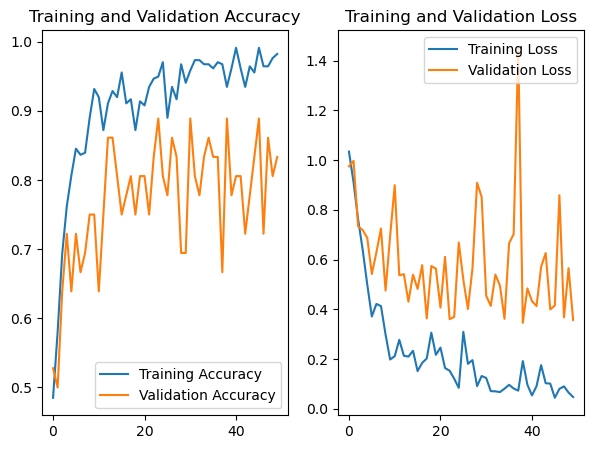

In [178]:
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [179]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


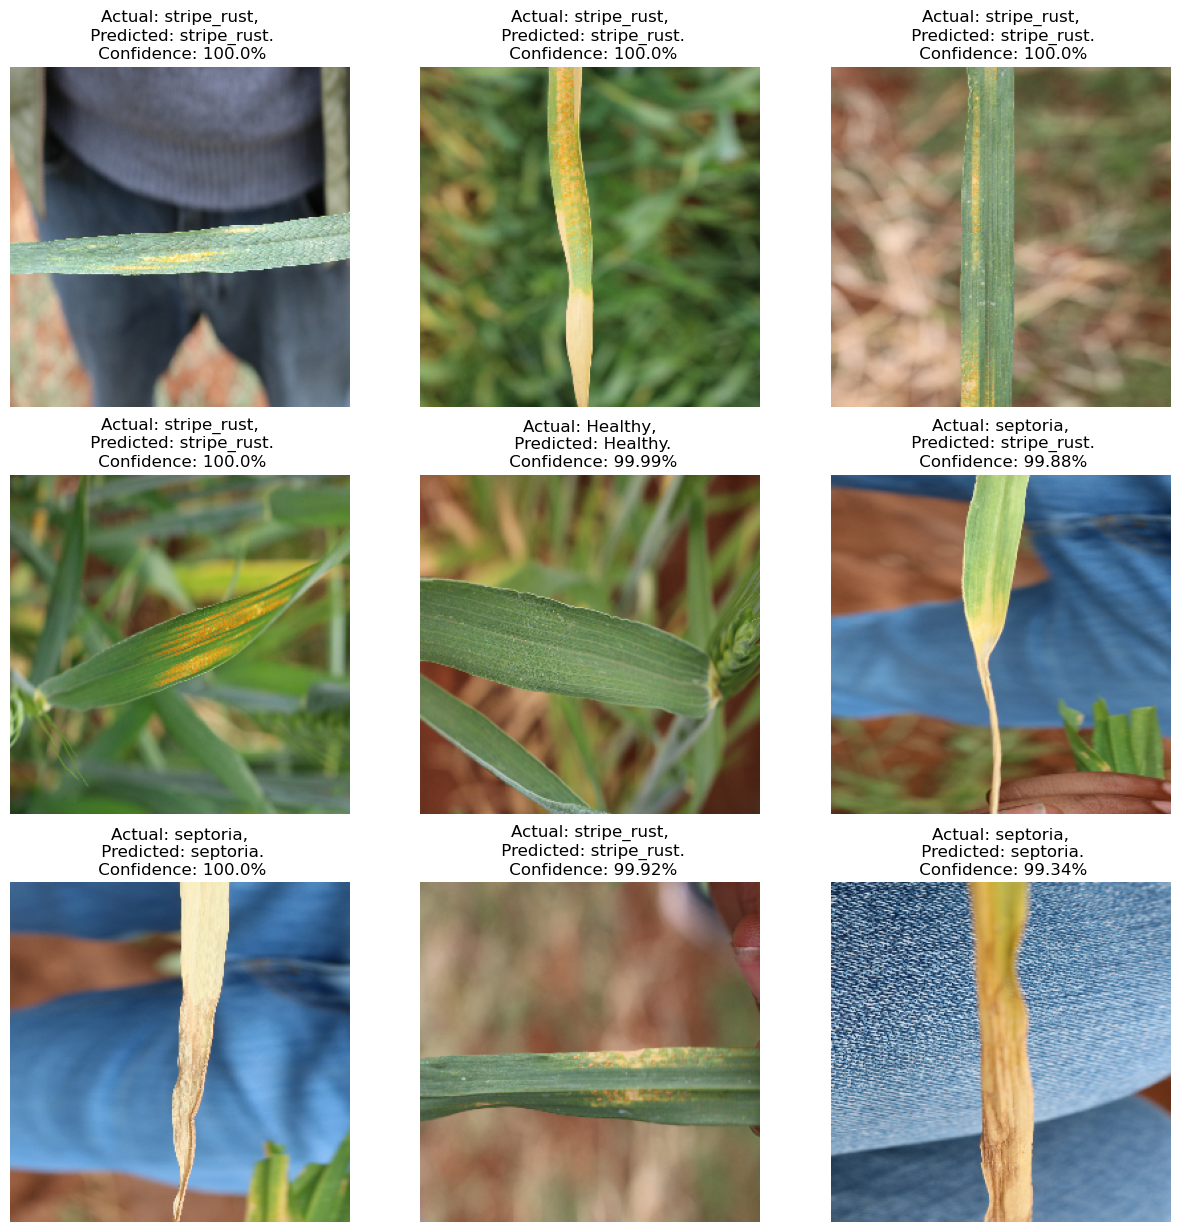

In [180]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [181]:
model_version = 1.0
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1.0\assets


INFO:tensorflow:Assets written to: ./models/1.0\assets
